In [10]:
import sys
sys.path.append('../')

import lib.graphLib.graph as g
from lib.graphLib.vertex import Vertex
from lib.graphLib.edge import Edge

from lib.constants import *
import lib.utils as utils

import igraph

##### Generate Test data

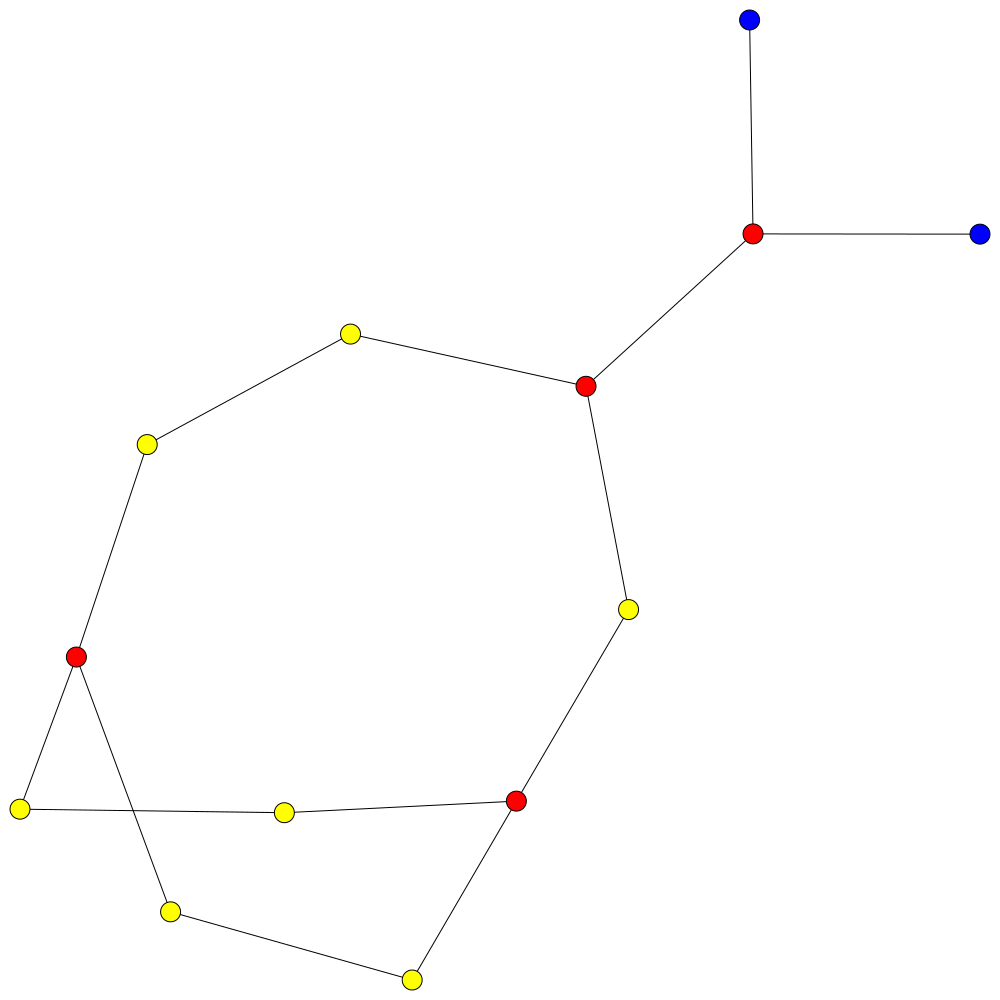

In [11]:
graph = g.Graph()

v0 = Vertex("red",attr={"coordinates":[165,50]})
v1 = Vertex("yellow",attr={"coordinates":[169,57]})
v2 = Vertex("yellow",attr={"coordinates":[196,52]})
v3 = Vertex("red",attr={"coordinates":[197,50]})
v4 = Vertex("yellow",attr={"coordinates":[193,43]})
v5 = Vertex("yellow",attr={"coordinates":[166,47]})

v6 = Vertex("yellow",attr={"coordinates":[242,47]})
v7 = Vertex("red",attr={"coordinates":[244,211]})
v8 = Vertex("yellow",attr={"coordinates":[90,220]})
v9 = Vertex("yellow",attr={"coordinates":[92,56]})

v10 = Vertex("red",attr={"coordinates":[245,240]})
v11 = Vertex("blue",attr={"coordinates":[259,241]})
v12 = Vertex("blue",attr={"coordinates":[229,241]})

graph.addVertices([v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12])
graph.addEdge(Edge(),v0.id,v1.id)
graph.addEdge(Edge(),v1.id,v2.id)
graph.addEdge(Edge(),v2.id,v3.id)
graph.addEdge(Edge(),v3.id,v4.id)
graph.addEdge(Edge(),v4.id,v5.id)
graph.addEdge(Edge(),v5.id,v0.id)

graph.addEdge(Edge(),v3.id,v6.id)
graph.addEdge(Edge(),v6.id,v7.id)
graph.addEdge(Edge(),v7.id,v8.id)
graph.addEdge(Edge(),v8.id,v9.id)
graph.addEdge(Edge(),v9.id,v0.id)

graph.addEdge(Edge(),v7.id,v10.id)
graph.addEdge(Edge(),v10.id,v11.id)
graph.addEdge(Edge(),v10.id,v12.id)

buildingParts = [
    ("resistor","horizontal",[v0,v1,v2,v3,v4,v5]),
    ("gound","vertical",[v10,v11,v12,])
]

igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("kk") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (200,200))

### Modify Graph

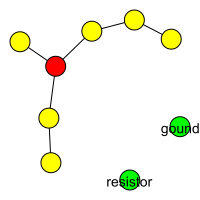

In [12]:
#Get all the vertices connected to a building part
for buildingPart in buildingParts:
    vertices = buildingPart[2]
    rotation = buildingPart[1]
    type_ = buildingPart[0]

    #get all intersections
    intersectionVertices = list (filter(lambda v: v.color == INTERSECTION_COLOR,vertices) )

    #match LTSpice Model connections with graph Model connections

    connectionMap = {}
    #TODO!! CHANGE
    index = 0
    for intersectionPoint in intersectionVertices:
        connectionMap[index] = intersectionPoint
        index+=1
    #TODO!! CHANGE

    #delete all vertices of the component accept the intersection points, change type to edge for them!
    for vertex in vertices:
        if vertex.color == INTERSECTION_COLOR:
            vertex.color = CORNER_COLOR
            continue
        graph.deleteVertex(vertex.id)
    
    #add UNCONECTED component Vertex
    component = Vertex(
            color=COMPONENT_COLOR,
            label=type_,
            attr={"connectionMap":connectionMap,"type":type_}
        )
    graph.addVertex(component)

igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (200,200))